# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
\begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

In [1]:
# import cv2
# from scipy import signal
# import math

import os
import requests
import numpy as np
import time

from math import floor
from matplotlib import pyplot as plt
from scipy.io import loadmat


url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/"

mr_data_FILENAME = "MR_data.mat"
if not os.path.exists(mr_data_FILENAME):
    r = requests.get(url + mr_data_FILENAME, allow_redirects=True)
    open(mr_data_FILENAME, "wb").write(r.content)

mr_data = loadmat(mr_data_FILENAME)

niose_free_image, noisy1_image, noisy2_image, noisy3_image, noisy4_image = [
    mr_data[filename]
    for filename in ["I_noisefree", "I_noisy1", "I_noisy2", "I_noisy3", "I_noisy4"]
]

In [2]:
def show_grayscale_image(
    ax, image, title=None, full_scale: bool = False, vmin=None, vmax=None, cmap="gray"
):
    vmin, vmax = (0, 256) if full_scale else (vmin, vmax)
    ax.axis("off")
    ax.imshow(image, cmap, vmin=vmin, vmax=vmax)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)


def present_image_difference(original_image, result_image):
    diff_image = result_image - original_image
    max_diff_val = max(diff_image.max(), -diff_image.min())

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(13, 4))

    show_grayscale_image(ax1, original_image, title="Original image", full_scale=True)
    show_grayscale_image(ax2, result_image, title="Convolution result", full_scale=True)
    show_grayscale_image(
        ax3,
        diff_image,
        title="Difference",
        cmap="bwr",
        vmin=-max_diff_val,
        vmax=max_diff_val,
    )


def gaussian_filer(size, sigma):
    def gauss_fun(d, sigma):
        return np.exp(-(d**2) / (2 * sigma**2))

    middle = size // 2
    result = np.zeros(shape=(size, size))
    for y in range(size):
        for x in range(size):
            result[y, x] = gauss_fun(
                np.sqrt((x - middle) ** 2 + (y - middle) ** 2), sigma
            )
    result /= result.sum()
    return result

In [3]:
def validate_window_size(window_size: int, variable_name: str = "window_size"):
    assert (
        window_size > 0
    ), f"`{variable_name}` must be a positive number, but was {window_size}"
    assert (
        window_size % 2 == 1
    ), f"`{variable_name}` must be an odd number, but was {window_size}"


def nonlocal_convolution(
    image, window_size: int, context_size: int, alpha: float, sigma: float
):
    validate_window_size(window_size, "window_size")
    validate_window_size(context_size, "context_size")

    gaussian = gaussian_filer(context_size, sigma)

    window_range = window_size // 2
    context_range = context_size // 2

    def context_distance(N_p, N_x):
        return np.linalg.norm(gaussian * N_p - gaussian * N_x)

    def w(N_p, N_x):
        return np.exp(-context_distance(N_p, N_x) / (alpha * sigma * sigma))

    def local_weighing(image_window):
        l_window = np.zeros(shape=(window_size, window_size))
        height, width = image_window.shape

        N_x = image_window[
            height // 2 - context_range : height // 2 + context_range + 1,
            width // 2 - context_range : width // 2 + context_range + 1,
        ]

        for x in range(context_range, image_window.shape[0] - context_range):
            for y in range(context_range, image_window.shape[1] - context_range):
                l_window[x - context_range, y - context_range] = w(
                    N_p=image_window[
                        x - context_range : x + context_range + 1,
                        y - context_range : y + context_range + 1,
                    ],
                    N_x=N_x,
                )

        l_window = l_window / np.sum(l_window)

        return np.sum(
            l_window
            * image_window[context_range:-context_range, context_range:-context_range]
        )

    height, width = image.shape
    margin = context_range + window_range
    result_image = np.copy(image)

    for y in range(margin, height - margin):
        for x in range(margin, width - margin):
            image_window = image[
                y - margin : y + margin + 1, x - margin : x + margin + 1
            ]
            result_image[y, x] = local_weighing(image_window)

    return np.round(result_image).astype(np.uint8)

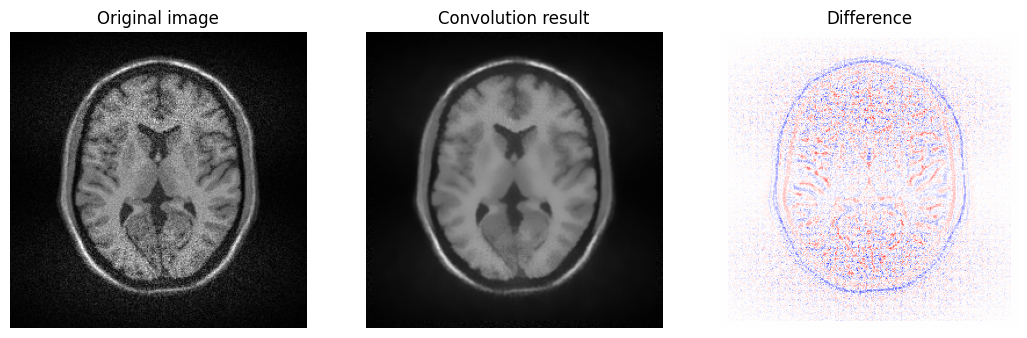

In [4]:
convoluted_image = nonlocal_convolution(
    image=noisy2_image, window_size=11, context_size=3, alpha=2.0, sigma=2.0
)

present_image_difference(noisy2_image, convoluted_image)

### Kod z części podstawowej

In [5]:
def convolution(image, window_size: int, sigma: float):
    validate_window_size(window_size)

    def new_pixel_value(surrounding, filter):
        return np.sum(surrounding * filter)

    filter = gaussian_filer(window_size, sigma)

    height, width = image.shape
    window_range = floor(window_size / 2)
    result_image = image.copy()
    for y in range(window_range, height - window_range):
        for x in range(window_range, width - window_range):
            result_image[y, x] = new_pixel_value(
                surrounding=image[
                    y - window_range : y + window_range + 1,
                    x - window_range : x + window_range + 1,
                ].copy(),
                filter=filter,
            )

    return np.round(result_image).astype(np.uint8)


def bilateral_convolution(image, window_size: int, sigma: float, sigma_r: float):
    validate_window_size(window_size)

    def gamma(brightness_diff):
        return np.exp(-(brightness_diff**2) / (2 * sigma_r**2))

    def new_pixel_value(surrounding, filter, pixel_value):
        altered_window = filter * gamma(pixel_value - surrounding)

        return np.sum(altered_window * surrounding) / np.sum(altered_window)

    filter = gaussian_filer(window_size, sigma)

    height, width = image.shape
    window_range = floor(window_size / 2)
    result_image = image.copy()
    for y in range(window_range, height - window_range):
        for x in range(window_range, width - window_range):
            result_image[y, x] = new_pixel_value(
                surrounding=image[
                    y - window_range : y + window_range + 1,
                    x - window_range : x + window_range + 1,
                ].copy(),
                filter=filter,
                pixel_value=image[y, x],
            )

    return np.round(result_image).astype(np.uint8)

### Porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM 
(2-3 zdania komentarza),

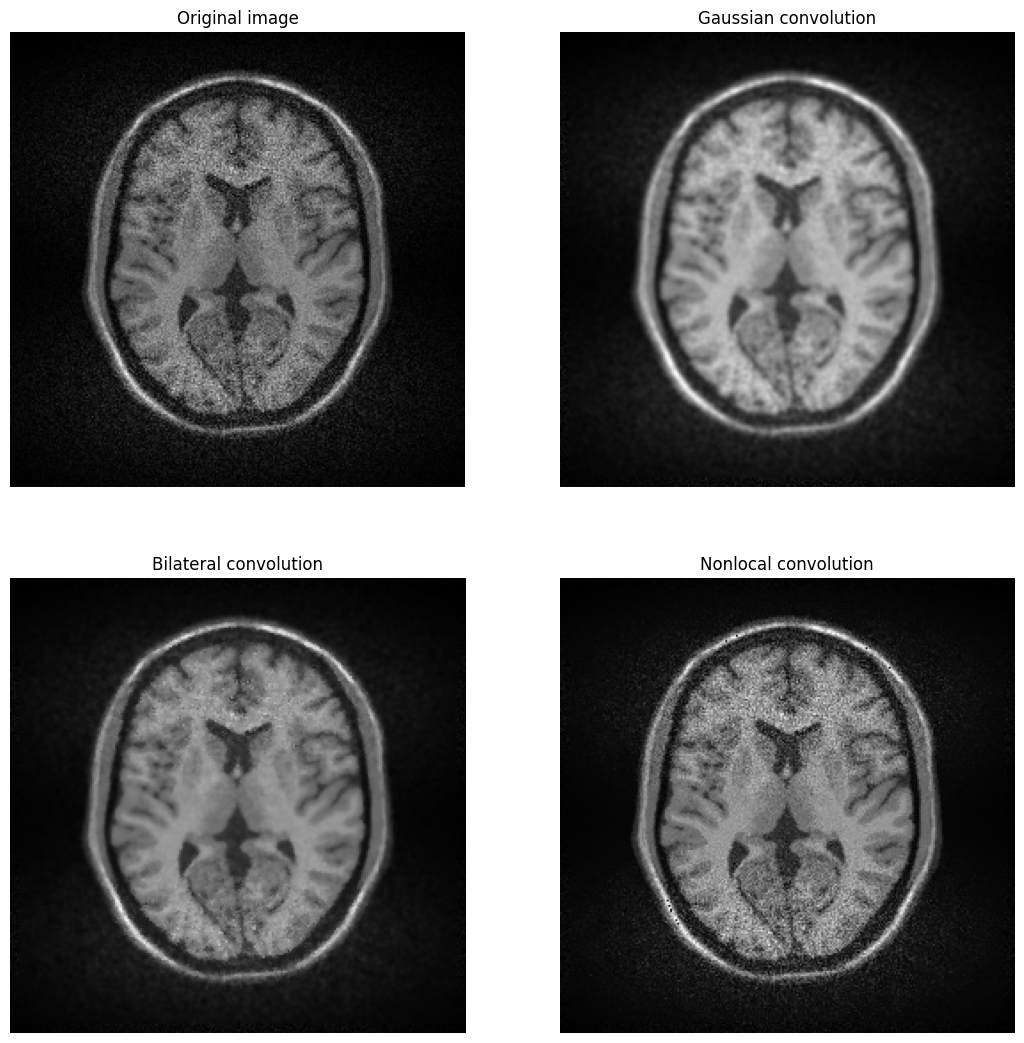

In [7]:
def compare_convolutions(
    original_image,
    window_size: int,
    sigma: float,
    sigma_r: int,
    context_size: int,
    alpha: float,
):
    gauss_conv_image = convolution(original_image, window_size, sigma)
    bilateral_conv_image = bilateral_convolution(
        original_image, window_size, sigma, sigma_r
    )
    nonlocal_conv_image = nonlocal_convolution(
        original_image, window_size, context_size, alpha, sigma
    )

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))

    for ax, (title, image) in zip(
        [ax for ax_row in axs for ax in ax_row],
        [
            ("Original image", original_image),
            ("Gaussian convolution", gauss_conv_image),
            ("Bilateral convolution", bilateral_conv_image),
            ("Nonlocal convolution", nonlocal_conv_image),
        ],
    ):
        show_grayscale_image(ax, image, title)


compare_convolutions(
    original_image=noisy2_image,
    window_size=11,
    sigma=1.0,
    sigma_r=50,
    context_size=3,
    alpha=1.0,
)

#### Komentarz

Filtracja Gaussa bardzo rozmywa obraz. Efekt ten jest nieco mniejszy w fultracji bilatelnej. Wynik filtracja _nonlocal_ jest bardzo zbliżony do obrazu oryginalnego, jednak nie identyczny. Być może wskazane byłoby wybranie innych hiperparametrów.

## Porównanie czasu działania powyższych metod

(1 zdanie komentarza).

Image:


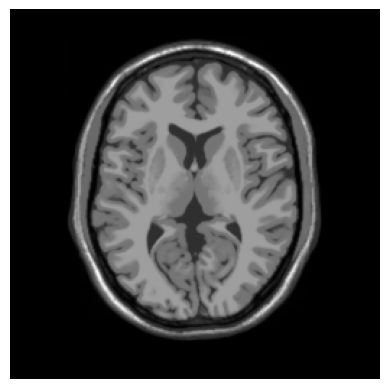

Measurements:
Gaussian convolution  - 0.84s
Bilateral convolution - 1.17s
Nonlocal convolution  - 49.85s


Image:


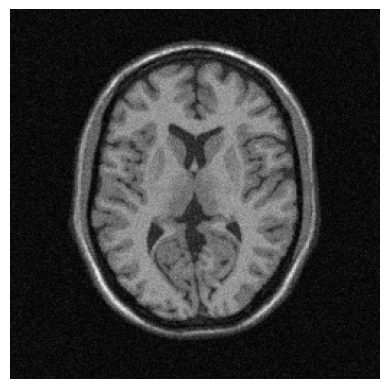

Measurements:
Gaussian convolution  - 0.31s
Bilateral convolution - 0.86s
Nonlocal convolution  - 45.57s


Image:


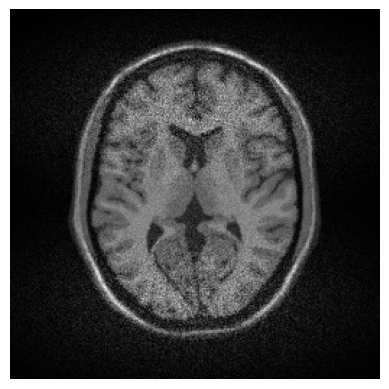

Measurements:
Gaussian convolution  - 0.30s
Bilateral convolution - 0.87s
Nonlocal convolution  - 46.41s


Image:


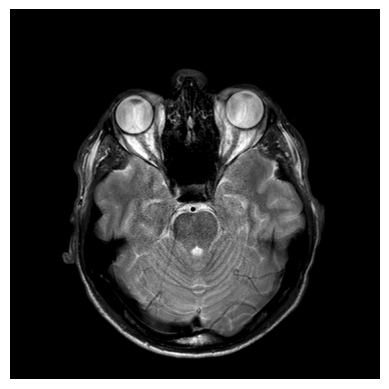

Measurements:
Gaussian convolution  - 1.75s
Bilateral convolution - 4.57s
Nonlocal convolution  - 263.64s


Image:


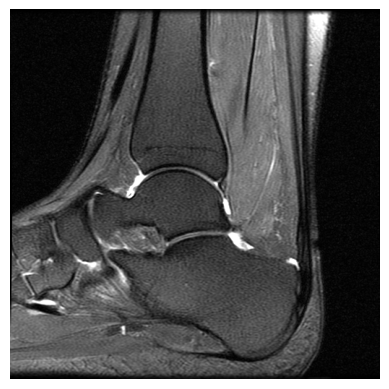

Measurements:
Gaussian convolution  - 1.36s
Bilateral convolution - 3.62s
Nonlocal convolution  - 185.92s




In [ ]:
def measure_execution_time(function, **kwargs):
    start_time = time.time()
    function_result = function(**kwargs)
    execution_time = time.time() - start_time

    return execution_time, function_result


def measure_convolution_time(
    image, window_size=11, sigma=2.0, sigma_r=50, context_size=3, alpha=2.0
):
    gauss_conv_time, _ = measure_execution_time(
        convolution, image=image, window_size=window_size, sigma=sigma
    )
    bilateral_conv_time, _ = measure_execution_time(
        bilateral_convolution,
        image=image,
        window_size=window_size,
        sigma=sigma,
        sigma_r=sigma_r,
    )
    nonlocal_conv_time, _ = measure_execution_time(
        nonlocal_convolution,
        image=image,
        window_size=window_size,
        context_size=context_size,
        alpha=alpha,
        sigma=sigma,
    )

    return gauss_conv_time, bilateral_conv_time, nonlocal_conv_time


for image in [niose_free_image, noisy1_image, noisy2_image, noisy3_image, noisy4_image]:
    print("Image:")
    show_grayscale_image(plt, image)
    plt.show()

    gauss_conv_time, bilateral_conv_time, nonlocal_conv_time = measure_convolution_time(
        image
    )

    measurements_msg = "\n".join(
        [
            f"{convolution_name} - {execution_time:.2f}s"
            for convolution_name, execution_time in [
                ("Gaussian convolution ", gauss_conv_time),
                ("Bilateral convolution", bilateral_conv_time),
                ("Nonlocal convolution ", nonlocal_conv_time),
            ]
        ]
    )
    print(f"Measurements:\n{measurements_msg}", end="\n\n\n")

#### Komentarz

Filtracja bilateralna jest **2**-**3** razy dłuższa od Gaussowskiej. Filtracja _nonlocal_ trwa **40**-**60** razy dłużej niż bilateralna!